IMDB Sentiment Classification Project CSCE 580 - Fall 2025

Models Compared
- Fine tuned DistilBERT
- base DistilBERT
- Classical ML
- GPT 2 prompt based classifier


In [1]:
#install if needed
# !pip install transformers torch scikit-learn pandas numpy matplotlib seaborn
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression


import torch
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    TrainingArguments, 
    Trainer,
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Using device: {device}")



 Using device: cpu


Section 1: Load and Split Dataset

We load the IMDB CSV from the 'data' folder, encode sentiments as 0 or 1, then create train, validation, and test splits using stratifies sampling to preserve label balance.

In [2]:
DATA_PATH = "../data/IMDB Dataset.csv"
df = pd.read_csv(DATA_PATH)
print(df.head())
print(df["sentiment"].value_counts())


# Encode labels: Positive -> 1, Negative -> 0
label_map = {"positive": 1, "negative": 0}
df["label"] = df["sentiment"].map(label_map)


X = df["review"].values
y = df["label"].values


#Train + val vs test
X_temp, X_test, y_temp, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)
#Train vs validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.1,
    random_state=42,
    stratify=y_temp,
)

print(f"Train size: {len(X_train)}, Val size: {len(X_val)}, Test size: {len(X_test)}")


                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
sentiment
positive    25000
negative    25000
Name: count, dtype: int64
Train size: 36000, Val size: 4000, Test size: 10000


Section 2: Preprocessing for DistilBERT

We use the 'distilbert-base-uncased' tokenizer.
Reviews are tokenized, truncated or padded to a fixed max length, and wrapped into a custom PyTorch 'Dataset'.

In [3]:
MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)


MAX_LEN = 256


class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = list(texts)
        self.labels = list(labels)
        self.tokenizer = tokenizer
        self.max_len = max_len


    def __len__(self):
        return len(self.texts)


    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )
        
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item


train_dataset = IMDBDataset(X_train, y_train, tokenizer, MAX_LEN)
val_dataset = IMDBDataset(X_val, y_val, tokenizer, MAX_LEN)
test_dataset = IMDBDataset(X_test, y_test, tokenizer, MAX_LEN)

In [4]:
import sys
!"{sys.executable}" -m pip install --upgrade accelerate



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


Section 3: Fine-tuning DistilBERT

We fine tune `distilbert-base-uncased` for binary sentiment classification using the Hugging Face Trainer API.  
We track accuracy, precision, recall, and F1 during evaluation.

In [5]:
fine_tuned_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
)
fine_tuned_model.to(device)

BATCH_SIZE = 16
EPOCHS = 3
LR = 2e-5

output_dir = "../models/distilbert_finetuned_imdb"

training_args = TrainingArguments(
    output_dir=output_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=LR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_dir="../logs",
    logging_steps=100,
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="binary", zero_division=0
    )
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

trainer = Trainer(
    model=fine_tuned_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

train_result = trainer.train()
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/81/zg373hd165z44mwdxb3_5pfh0000gn/T/ipykernel_93174/2772457335.py:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/alim/CSCE_580/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.231000,0.212387,0.914500,0.913673,0.915500,0.914585
2,0.163800,0.277722,0.911500,0.905020,0.919500,0.912202
3,0.110500,0.343500,0.915250,0.913390,0.917500,0.915440


/Users/alim/CSCE_580/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/alim/CSCE_580/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


('../models/distilbert_finetuned_imdb/tokenizer_config.json',
 '../models/distilbert_finetuned_imdb/special_tokens_map.json',
 '../models/distilbert_finetuned_imdb/vocab.txt',
 '../models/distilbert_finetuned_imdb/added_tokens.json',
 '../models/distilbert_finetuned_imdb/tokenizer.json')

Section 4: Plot and Accuracy and Loss Curves

We inspect training and validation loss and validation accuracy over steps.  
This helps comment on convergence and possible overfitting in the report.


,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_accuracy,eval_precision,eval_recall,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
66,0.0839,0.210319,7.437037e-07,2.888889,6500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,0.1102,2.494935,4.474074e-07,2.933333,6600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,0.1105,2.638402,1.511111e-07,2.977778,6700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69,NaN,NaN,NaN,3.000000,6750,0.3435,0.91525,0.91339,0.9175,0.91544,97.0957,41.196,2.575,NaN,NaN,NaN,NaN,NaN
70,NaN,NaN,NaN,3.000000,6750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5958.6323,18.125,1.133,7.153240e+15,0.181022


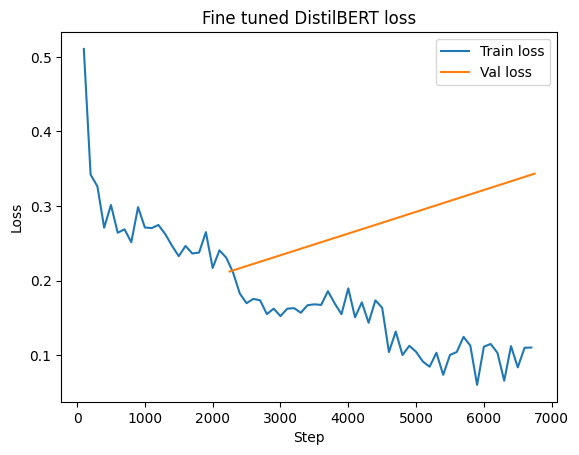

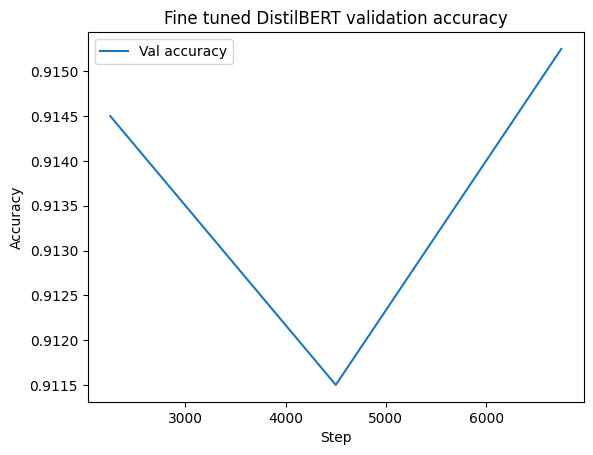

In [6]:
logs = pd.DataFrame(trainer.state.log_history)
display(logs.tail())

train_loss = logs[logs["loss"].notna()]
eval_loss  = logs[logs["eval_loss"].notna()]
eval_acc   = logs[logs["eval_accuracy"].notna()]

plt.figure()
plt.plot(train_loss["step"], train_loss["loss"], label="Train loss")
plt.plot(eval_loss["step"],  eval_loss["eval_loss"], label="Val loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Fine tuned DistilBERT loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(eval_acc["step"], eval_acc["eval_accuracy"], label="Val accuracy")
plt.xlabel("Step")
plt.ylabel("Accuracy")
plt.title("Fine tuned DistilBERT validation accuracy")
plt.legend()
plt.show()


Section 5: Evaluation of fine tuned DistilBERT

We evaluate the fine tuned model on the held out test set and record accuracy, precision, recall, F1, and the confusion matrix.

In [7]:
predictions_ft = trainer.predict(test_dataset)
test_logits_ft = predictions_ft.predictions
y_pred_ft = np.argmax(test_logits_ft, axis=-1)

print("Fine tuned DistilBERT test accuracy:",
      accuracy_score(y_test, y_pred_ft))
print(classification_report(y_test, y_pred_ft, target_names=["negative", "positive"]))

cm_ft = confusion_matrix(y_test, y_pred_ft)
cm_ft


/Users/alim/CSCE_580/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Fine tuned DistilBERT test accuracy: 0.9141
              precision    recall  f1-score   support

    negative       0.92      0.91      0.91      5000
    positive       0.91      0.92      0.91      5000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



array([[4541,  459],
       [ 400, 4600]])

Section 6: Base DistilBERT without fine tuning

We load the base DistilBERT model with a classification head but without training on the IMDB data.  
This acts as the base transformer comparison in the project.

In [8]:
base_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
)
base_model.to(device)

base_trainer = Trainer(
    model=base_model,
    args=TrainingArguments(
        output_dir="../models/distilbert_base_imdb",
        per_device_eval_batch_size=BATCH_SIZE,
    ),
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

base_predictions = base_trainer.predict(test_dataset)
base_logits = base_predictions.predictions
y_pred_base = np.argmax(base_logits, axis=-1)

print("Base DistilBERT test accuracy:",
      accuracy_score(y_test, y_pred_base))
print(classification_report(y_test, y_pred_base, target_names=["negative", "positive"]))

cm_base = confusion_matrix(y_test, y_pred_base)
cm_base


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/81/zg373hd165z44mwdxb3_5pfh0000gn/T/ipykernel_93174/3198240583.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  base_trainer = Trainer(
/Users/alim/CSCE_580/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Base DistilBERT test accuracy: 0.5007
              precision    recall  f1-score   support

    negative       0.50      0.99      0.67      5000
    positive       0.56      0.01      0.01      5000

    accuracy                           0.50     10000
   macro avg       0.53      0.50      0.34     10000
weighted avg       0.53      0.50      0.34     10000



array([[4975,   25],
       [4968,   32]])

Section 7: Classical machine learning baseline

We build a baseline model using TF IDF features and Logistic Regression.  
This is our classical statistical model for comparison.

In [9]:
vectorizer = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 2),
    stop_words="english",
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf   = vectorizer.transform(X_val)
X_test_tfidf  = vectorizer.transform(X_test)

clf = LogisticRegression(max_iter=1000)

start_train_clf = time.time()
clf.fit(X_train_tfidf, y_train)
train_time_clf = time.time() - start_train_clf

start_infer_clf = time.time()
y_pred_clf = clf.predict(X_test_tfidf)
infer_time_clf = time.time() - start_infer_clf

print("Classical model (LogReg) test accuracy:",
      accuracy_score(y_test, y_pred_clf))
print(classification_report(y_test, y_pred_clf, target_names=["negative", "positive"]))

cm_clf = confusion_matrix(y_test, y_pred_clf)
cm_clf

print(f"Classical train time: {train_time_clf:.2f} s")
print(f"Classical inference time on test: {infer_time_clf:.2f} s")


Classical model (LogReg) test accuracy: 0.9008
              precision    recall  f1-score   support

    negative       0.91      0.89      0.90      5000
    positive       0.89      0.91      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

Classical train time: 0.25 s
Classical inference time on test: 0.00 s


Section 8: GPT 2 prompt based classification

We use a GPT style causal language model (`openai-community/gpt2`) as a sentiment classifier using prompts.  
To keep runtime reasonable, we evaluate on a subset of the test set.  
We then compute accuracy, precision, recall, F1, and a confusion matrix for that subset.

In [10]:
from transformers import AutoTokenizer, AutoModelForCausalLM

GPT_MODEL_NAME = "openai-community/gpt2"

gpt_tokenizer = AutoTokenizer.from_pretrained(GPT_MODEL_NAME)
gpt_model = AutoModelForCausalLM.from_pretrained(GPT_MODEL_NAME).to(device)

# GPT 2 does not have a pad token by default, so we reuse eos token
if gpt_tokenizer.pad_token is None:
    gpt_tokenizer.pad_token = gpt_tokenizer.eos_token

gpt_model.eval()

def classify_with_gpt2(review, max_new_tokens=8):
    """
    Simple prompt based sentiment classification using GPT 2.
    It looks for the words 'positive' or 'negative' in the generated continuation.
    """
    prompt = (
        "You are a sentiment classifier. "
        "Decide whether the following movie review is Positive or Negative.\n\n"
        f"Review: {review}\n"
        "Sentiment:"
    )

    inputs = gpt_tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=512,
    ).to(device)

    with torch.no_grad():
        outputs = gpt_model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            pad_token_id=gpt_tokenizer.eos_token_id,
        )

    generated = gpt_tokenizer.decode(outputs[0], skip_special_tokens=True)
    tail = generated.split("Sentiment:")[-1].strip().lower()

    if "positive" in tail:
        return 1
    if "negative" in tail:
        return 0

    # fallback guess
    return 1

# Evaluate GPT 2 on a subset of the test set for speed
N_GPT_TEST = 300  # you can adjust this if it is too slow
X_test_sub = X_test[:N_GPT_TEST]
y_test_sub = y_test[:N_GPT_TEST]

gpt_preds = []
start_gpt = time.time()
for text in X_test_sub:
    gpt_preds.append(classify_with_gpt2(text))
gpt_infer_time = time.time() - start_gpt

gpt_preds = np.array(gpt_preds)

print("GPT 2 subset test accuracy:",
      accuracy_score(y_test_sub, gpt_preds))
print(classification_report(y_test_sub, gpt_preds, target_names=["negative", "positive"]))

cm_gpt = confusion_matrix(y_test_sub, gpt_preds)
cm_gpt

print(f"GPT 2 inference time on {N_GPT_TEST} samples: {gpt_infer_time:.2f} s")


GPT 2 subset test accuracy: 0.56
              precision    recall  f1-score   support

    negative       0.92      0.08      0.14       142
    positive       0.55      0.99      0.70       158

    accuracy                           0.56       300
   macro avg       0.73      0.54      0.42       300
weighted avg       0.72      0.56      0.44       300

GPT 2 inference time on 300 samples: 167.10 s


Section 9: Confusion matrices and metrics comparison

We plot confusion matrices for all models and build a summary table with accuracy, precision, recall, and F1.  
For GPT 2 the metrics are based on the evaluated subset.

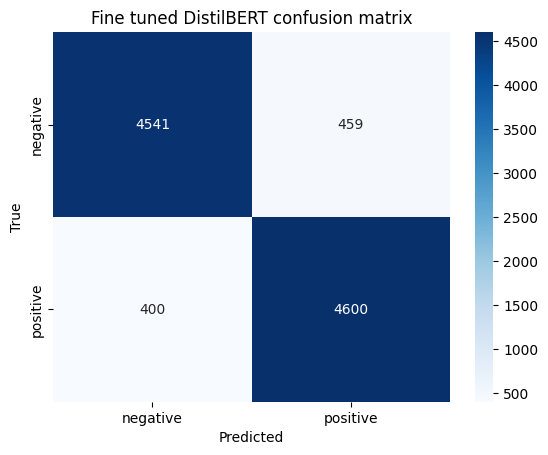

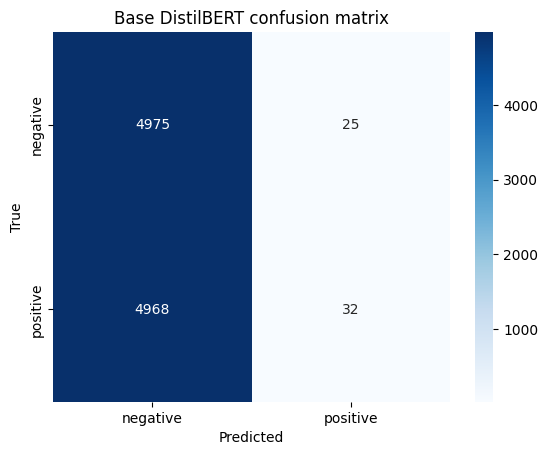

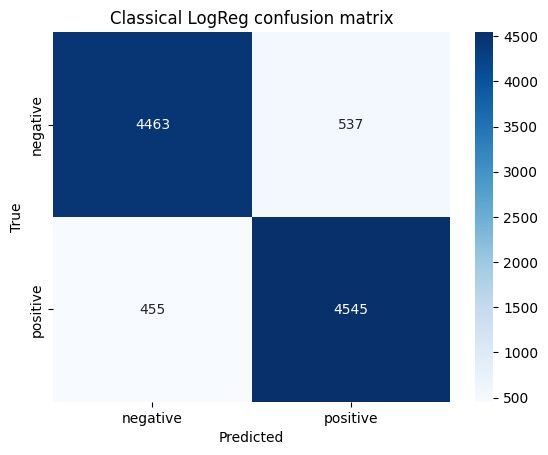

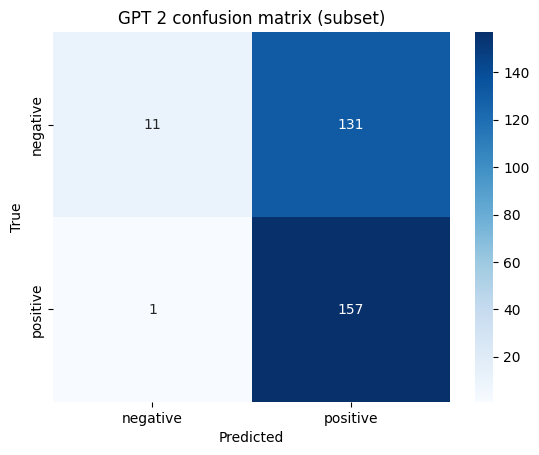

In [11]:
def plot_cm(cm, title):
    plt.figure()
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["negative", "positive"],
        yticklabels=["negative", "positive"],
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

plot_cm(cm_ft,   "Fine tuned DistilBERT confusion matrix")
plot_cm(cm_base, "Base DistilBERT confusion matrix")
plot_cm(cm_clf,  "Classical LogReg confusion matrix")
plot_cm(cm_gpt,  "GPT 2 confusion matrix (subset)")

def get_metrics(y_true, y_pred, name):
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )
    return {
        "Model": name,
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
    }

rows = []
rows.append(get_metrics(y_test,     y_pred_ft,   "Fine tuned DistilBERT"))
rows.append(get_metrics(y_test,     y_pred_base, "Base DistilBERT"))
rows.append(get_metrics(y_test,     y_pred_clf,  "Classical Logistic Regression"))
rows.append(get_metrics(y_test_sub, gpt_preds,   "GPT 2 (subset)"))

metrics_df = pd.DataFrame(rows)
metrics_df
metrics_df.to_csv("../results/model_metrics.csv", index=False)


Section 10: AI test cases

We define a small set of custom reviews with known sentiment and run all four models on each.  
These results can be copied into the AI testcase template in the project guidelines.

In [14]:
import torch

fine_tuned_model.to("cpu")
base_model.to("cpu")

test_cases = [
    "This movie was amazing. The acting was brilliant and I loved every minute of it.",
    "I really wanted to enjoy this film but it was boring and way too long.",
    "The visuals were impressive but the story was confusing and the characters were flat.",
]

def predict_with_distilbert(model, text):
    encoded = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN,
        return_tensors="pt",
    )
    
    model_device = next(model.parameters()).device
    encoded = {k: v.to(model_device) for k, v in encoded.items()}

    with torch.no_grad():
        logits = model(**encoded).logits
    pred = int(torch.argmax(logits, dim=-1).cpu().item())
    return pred  
def predict_with_classical(text):
    vec = vectorizer.transform([text])
    return int(clf.predict(vec)[0])

for t in test_cases:
    ft = predict_with_distilbert(fine_tuned_model, t)
    base = predict_with_distilbert(base_model, t)
    clf_pred = predict_with_classical(t)
    gpt_pred = classify_with_gpt2(t)

    print(f"\nReview: {t}")
    print(f"  Fine tuned DistilBERT: {ft}")
    print(f"  Base DistilBERT:       {base}")
    print(f"  Classical LogReg:      {clf_pred}")
    print(f"  GPT 2:                 {gpt_pred}")
    print("  (1 = positive, 0 = negative)")



Review: This movie was amazing. The acting was brilliant and I loved every minute of it.
  Fine tuned DistilBERT: 1
  Base DistilBERT:       0
  Classical LogReg:      1
  GPT 2:                 1
  (1 = positive, 0 = negative)

Review: I really wanted to enjoy this film but it was boring and way too long.
  Fine tuned DistilBERT: 0
  Base DistilBERT:       0
  Classical LogReg:      0
  GPT 2:                 1
  (1 = positive, 0 = negative)

Review: The visuals were impressive but the story was confusing and the characters were flat.
  Fine tuned DistilBERT: 0
  Base DistilBERT:       0
  Classical LogReg:      0
  GPT 2:                 1
  (1 = positive, 0 = negative)
